# Validation

This notebook will compare the outputs of measurements done with napari-stress to those of the legacy-version [STRESS](https://github.com/campaslab/STRESS) as well as performing a theoretical analysis of measured curvatures on an ideal ellipsoid.

## Legacy validation

First, we compare the results of the legacy version of STRESS to the results of napari-stress.

We compare **three analysis workflows**:

* Using the reconstruction and the measurement from STRESS
* Using the STRESS reconstruction and the measurement from napari-stress
* using the napari-stress reconstruction and the measurement from napari-stress

We compare the reconstruction and measured quantities for the following **synthetic data**:

* Ideal sphere
* Ideal ellipsoid

## Comparisons:

For all workflows, we compare the following quantities:

* The reconstructed pointcloud: Since the reconstructed object should be perfectly spherical, we can convert the reconstructed pointcloud coordinates to [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) and compare the distribution of radii of both reconstructions. 
* Measured mean curvatures: Similar to the distribution of measured radii, the measured mean curvatures should follow a similar and ideally narrow distributioin
* Total [stress anisotropies](https://www.biorxiv.org/content/10.1101/2021.03.26.437148v1.full): For an ideal sphere, these should be as close to zero as possible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import napari
import pandas as pd
import vedo
import seaborn as sns

from skimage import filters
from napari_stress import sample_data, reconstruction, measurements

In [4]:
viewer = napari.Viewer()

# Sphere

We begin with comparing measurements for the ideal sphere. For this we load the data that was created with all listed measurement approaches:

In [5]:
dataset = os.path.join('.', 'results_sphere')

In [6]:
pointcloud_stress0 = pd.read_csv(os.path.join(dataset, 'stress_analysis_and_stress_pointcloud', 'pointcloud.csv'), sep=',', header=None).to_numpy()
pointcloud_napari_stress0 = pd.read_csv(os.path.join(dataset, 'napari_stress_analysis_and_napari_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()

### Radii

To better compare the two pointcouds visually, we can convert both to relative coordinates by subtracting the pointcloud's center from every point:

In [7]:
pointcloud_stress0_centered = pointcloud_stress0 - pointcloud_stress0.mean(axis=0)[None, :]
pointcloud_napari_stress0_centered = pointcloud_napari_stress0 - pointcloud_napari_stress0.mean(axis=0)[None, :]

We can convert the points into spherical coordinates and measure the distribution of radii. For an ideal sphere, the standard deviation $\sigma$ of the radii should be zero:

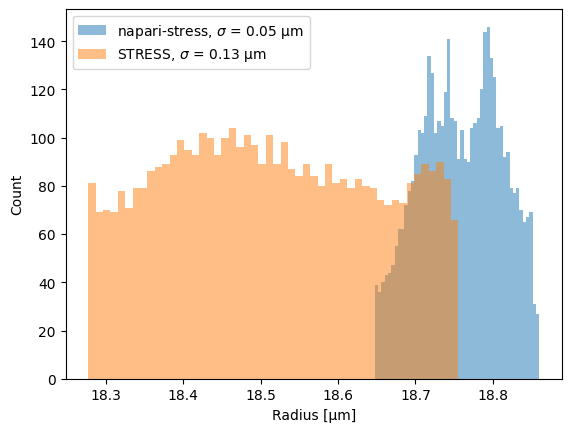

In [8]:
r_ns, phi_ns, theta_ns = vedo.cart2spher(pointcloud_napari_stress0_centered[:, 0], pointcloud_napari_stress0_centered[:, 1], pointcloud_napari_stress0_centered[:, 2])
r_s, phi_s, theta_s = vedo.cart2spher(pointcloud_stress0_centered[:, 0], pointcloud_stress0_centered[:, 1], pointcloud_stress0_centered[:, 2])

mpl.style.use('default')
fig, ax = plt.subplots()
ax.hist(r_ns, 50, label='napari-stress, $\sigma$ = {:.2f} µm'.format(r_ns.std()), alpha=0.5)
ax.hist(r_s, 50, label='STRESS, $\sigma$ = {:.2f} µm'.format(r_s.std()), alpha=0.5)
ax.set_xlabel('Radius [µm]')
ax.set_ylabel('Count')
ax.legend()

In [9]:
for layer in viewer.layers:
    layer.visible = False
viewer.add_points(pointcloud_napari_stress0_centered, properties={'radius': r_ns}, face_color='radius', size=1)
viewer.add_points(pointcloud_stress0_centered, properties={'radius': r_s}, face_color='radius', size=1)

<Points layer 'pointcloud_stress0_centered' at 0x2b0424ccf40>

For napari-stress, you see some small variations across the surface

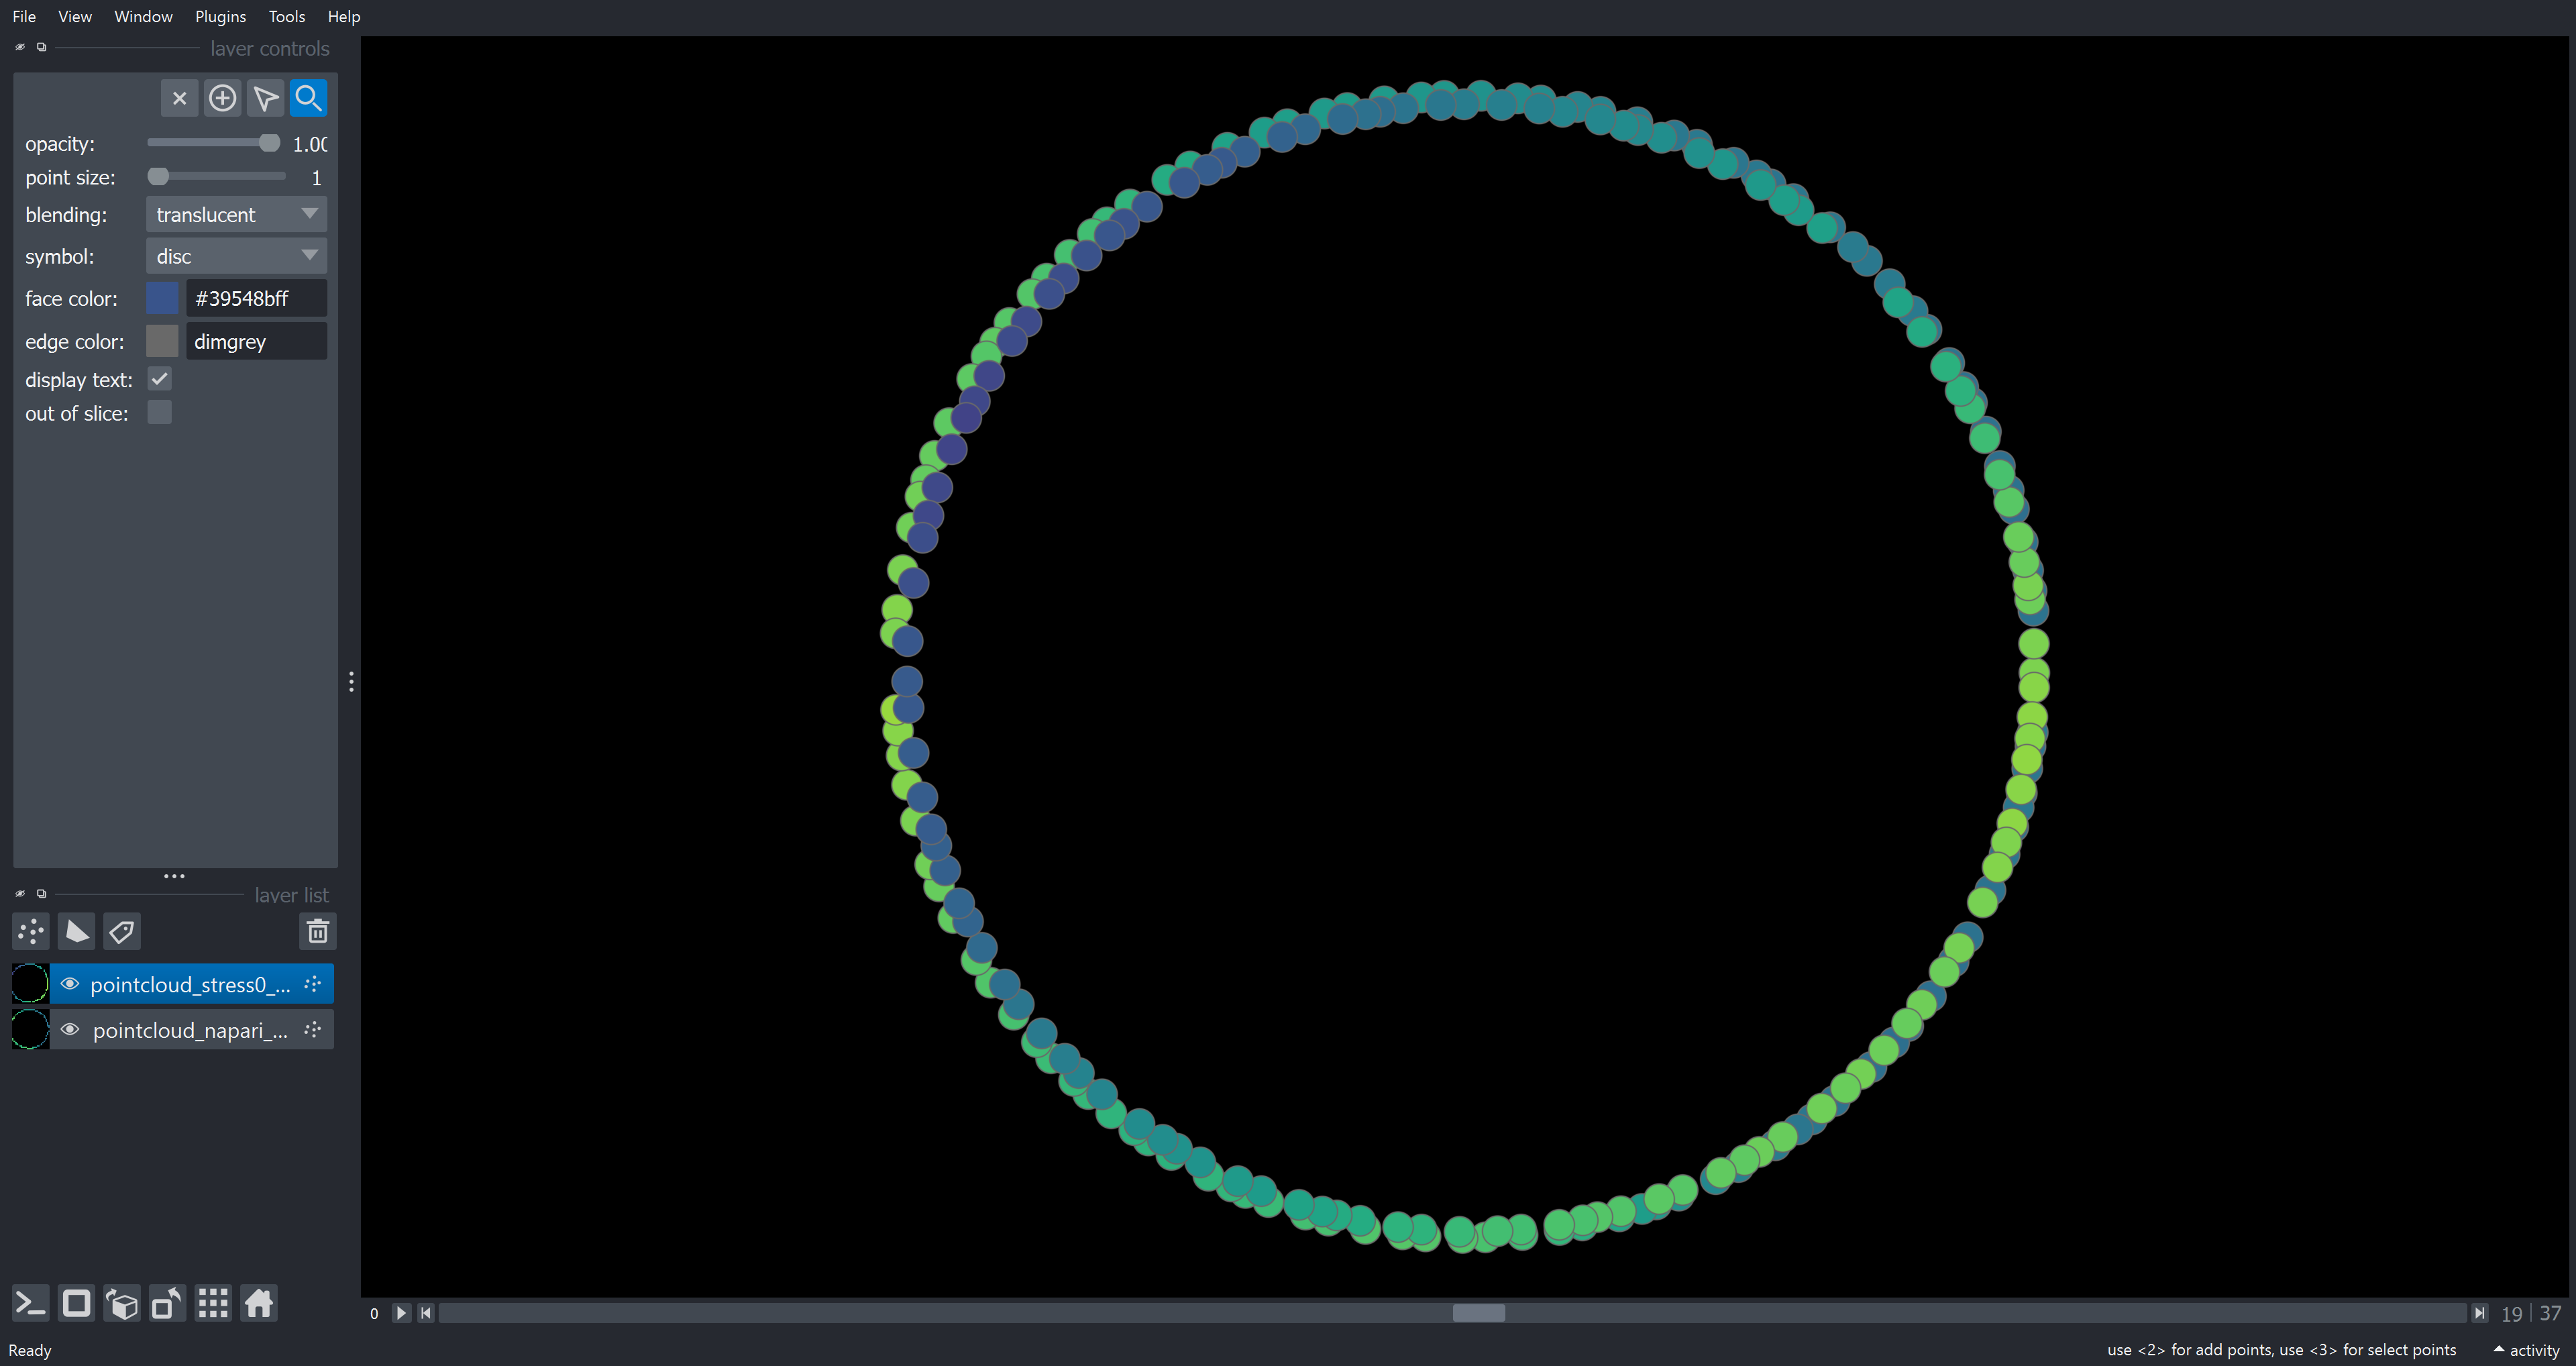

In [10]:
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Mean curvatures

Here, we compare the measured mean curvatures for each of the above-described workflows. The measured mean curvatures are compared to the expected mean curvatures for an ieal sphere with the above-introduced formula. Since the creation of an grayscale image of an ideal sphere from a spherical pointcloud will likely not yield an image with an intensity crossover of 50% exactly at the given radius of the used pointcloud, we expect a systematic bias in the measurement of mean curvature.

To unravel this effect, we also calculate the axis lengths of the reconstructed pointcloud and calculate theoretical mean curvatures for its particular size:

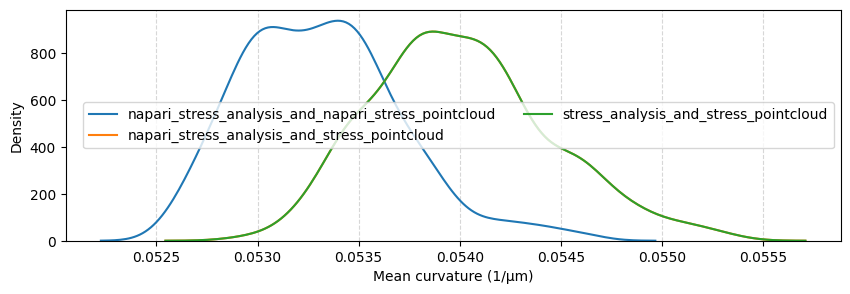

In [11]:
mpl.style.use('default')

fig, ax = plt.subplots(figsize=(10,3))
file = 'mean_curvatures.csv'
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    mean_curvatures = np.loadtxt(os.path.join(dataset, directory, file))
    
    sns.kdeplot(data=mean_curvatures, ax=ax, label=directory)

ax.set_xlabel('Mean curvature (1/µm)')
ax.grid(which='major', axis='x', linestyle='--', alpha=0.5)

ax.legend(ncols=2)

## Compare stresses

Here we compare total/cell/tissue stresses for the three workflows:

In [12]:
def calculate_anisotropy(values, alpha=0.05):
    from scipy import stats
    hist_data = np.histogram(values, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)

    return largest_excluded_value - smallest_excluded_value

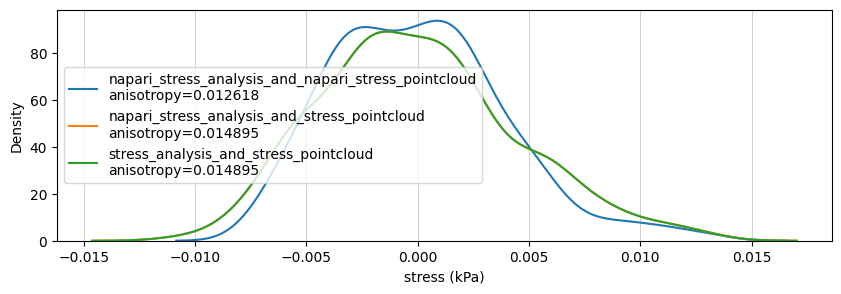

In [13]:
fig, ax = plt.subplots(figsize=(10,3))
file = 'total_stress.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    total_stresses = np.loadtxt(os.path.join(dataset, directory, file))
    anisotropy = calculate_anisotropy(total_stresses)
    sns.kdeplot(data=total_stresses, ax=ax, label=directory+'\nanisotropy={:2f}'.format(anisotropy))
    ax.set_xlabel('stress (kPa)')
    ax.grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)

    ax.legend()
    idx += 1


# Ellipsoid

In this section, we repeat the analysis workflow from above for synthetic data of an ellipsoid with major axis lengths of `(20, 15, 15)`.

In [14]:
dataset = os.path.join('.', 'results_ellipsoid')

In [15]:
pointcloud_stress0 = pd.read_csv(os.path.join(dataset, 'stress_analysis_and_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()
pointcloud_napari_stress0 = pd.read_csv(os.path.join(dataset, 'napari_stress_analysis_and_napari_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()

In [16]:
viewer2 = napari.Viewer()

Again, we center the pointclouds to be able to compare them better on top of each other:

In [17]:
pointcloud_stress0_centered = pointcloud_stress0 - pointcloud_stress0.mean(axis=0)[None, :]
pointcloud_napari_stress0_centered = pointcloud_napari_stress0 - pointcloud_napari_stress0.mean(axis=0)[None, :]

In [18]:
viewer2.add_points(pointcloud_stress0_centered, size=0.5, name='pointcloud STRESS')
viewer2.add_points(pointcloud_napari_stress0_centered, size=0.5, face_color='orange', name='pointcloud napari stress')

<Points layer 'pointcloud napari stress' at 0x2b055cf8e50>

It carries limited information for ellipsoidal data, but for completeness we also measure the radii of each point in spherical coordinates:

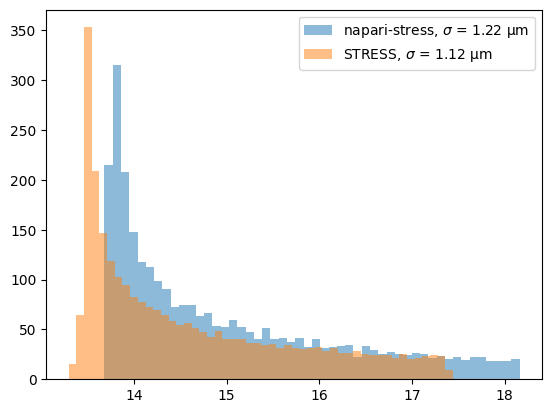

In [19]:
r_ns, phi_ns, theta_ns = vedo.cart2spher(pointcloud_napari_stress0_centered[:, 0], pointcloud_napari_stress0_centered[:, 1], pointcloud_napari_stress0_centered[:, 2])
r_s, phi_s, theta_s = vedo.cart2spher(pointcloud_stress0_centered[:, 0], pointcloud_stress0_centered[:, 1], pointcloud_stress0_centered[:, 2])

mpl.style.use('default')
fig, ax = plt.subplots()
ax.hist(r_ns, 50, label='napari-stress, $\sigma$ = {:.2f} µm'.format(r_ns.std()), alpha=0.5)
ax.hist(r_s, 50, label='STRESS, $\sigma$ = {:.2f} µm'.format(r_s.std()), alpha=0.5)
ax.legend()

## Mean curvatures

We now plot the distribution of mean curvatures on the synthetic ellipsoid for the three experimental workflows described above.  It is not clear whether the process of creating the synthetic image data delivers an ellipsoid image with the same major axis lengths which were used to create the initial pointcloud (see [this notebook](./create_validation_data.ipynb)). 

Hence, we compare the measured mean curvatures with both the originally used major axis lenghts (`20, 15, 15`) as well as with the axis lengths of the pointclouds that were recovered with the respective methods:

In [20]:
axis_lengths = (20, 15, 15)
axis_lengths = np.sort(axis_lengths)[::-1]
print('a = {:.2f} px, b = {:.2f} px, c = {:.2f} px'.format(*axis_lengths))

a = 20.00 px, b = 15.00 px, c = 15.00 px


(0.0, 100.0)

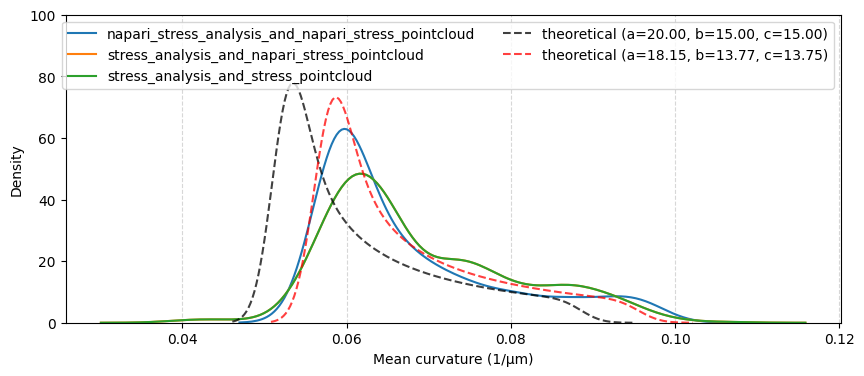

In [21]:
mpl.style.use('default')

fig, ax = plt.subplots(figsize=(10,4))
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.exists(os.path.join(dataset, directory, 'mean_curvatures.csv')):
        continue

    mean_curvatures = np.loadtxt(os.path.join(dataset, directory, 'mean_curvatures.csv'))
    recovered_pointcloud = np.loadtxt(os.path.join(dataset, directory, 'pointcloud.csv'))
    recovered_axis_lengths = np.sort(pointcloud_napari_stress0_centered.max(axis=0) - pointcloud_napari_stress0_centered.min(axis=0))[::-1]/2

    mean_curvatures_theoretical = theoretical_mean_curvature_on_pointcloud(
        axis_lengths[0],
        axis_lengths[1],
        axis_lengths[2],
        pointcloud_napari_stress0_centered)
    mean_curvatures_theoretical_recovered = theoretical_mean_curvature_on_pointcloud(
        recovered_axis_lengths[0],
        recovered_axis_lengths[1],
        recovered_axis_lengths[2],
        pointcloud_napari_stress0_centered)

    sns.kdeplot(data=mean_curvatures, ax=ax, label=directory)
sns.kdeplot(data=mean_curvatures_theoretical, ax=ax, label='theoretical (a={:.2f}, b={:.2f}, c={:.2f})'.format(*axis_lengths), color='k', linestyle='--',
            alpha=0.75)
sns.kdeplot(data=mean_curvatures_theoretical_recovered, ax=ax, label='theoretical (a={:.2f}, b={:.2f}, c={:.2f})'.format(*recovered_axis_lengths), color='r',
            linestyle='--', alpha=0.75)
ax.set_xlabel('Mean curvature (1/µm)')
ax.grid(which='major', axis='x', linestyle='--', alpha=0.5)

ax.legend(ncols=2)
ax.set_ylim(0, 100)

## Total stress

We plot the same curve for total stress:

(0.0, 10.0)

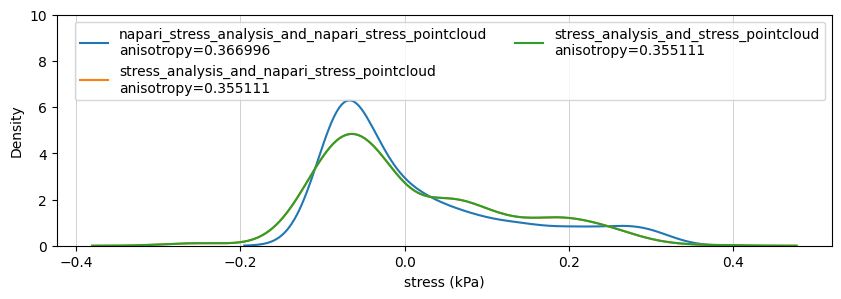

In [22]:
fig, ax = plt.subplots(figsize=(10,3))
file = 'total_stress.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.exists(os.path.join(dataset, directory, file)):
        continue

    total_stresses = np.loadtxt(os.path.join(dataset, directory, file))
    anisotropy = calculate_anisotropy(total_stresses)
    sns.kdeplot(data=total_stresses, ax=ax, label=directory+'\nanisotropy={:2f}'.format(anisotropy))
ax.set_xlabel('stress (kPa)')
ax.grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)

ax.legend(ncols=2)
ax.set_ylim(0, 10)

# Benchmarking

In this section, we benchmark the performance of napari-stress independently of the legacy version of STRESS. This is done by performing two tests on aynthetic image data of a blurry ellipsoid:

* We reconstruct the pointcloud with napari-stress. We then measure the deviation of the recovered point cloud from the original pointcloud.
* We measure the mean curvatures of the ellipsoid with napari-stress. We then compare the measured mean curvatures to the theoretical mean curvatures of the same ellipsoid.

### Relative deviation of pointcloud

In the next cell, we create a list of major axis lengths for which we want to calculate the theoretical mean curvatures. The different set of major axis lengths is used to test the robustness of the mean curvature calculation and corresponds to ellipsoids of different aspect ratios.

The relative deviation of the pointcloud is calculated as the average deviation of every traced point from its corresponding correct location in x,y and z divided by the respective point's true location in x,y and z.

In [3]:
def project_point_on_ellipse_surface(query_point: np.ndarray,
                                     a: float,
                                     b: float,
                                     c: float,
                                     center: np.ndarray) -> np.ndarray:
    """Project a point on the surface of an ellipsoid.

    Parameters
    ----------
    query_point : np.ndarray
        Point to project on the surface of the ellipsoid.
    a : float
        Length of the first axis of the ellipsoid.
    b : float
        Length of the second axis of the ellipsoid.
    c : float
        Length of the third axis of the ellipsoid.
    center : np.ndarray
        Center of the ellipsoid.

    Returns
    -------
    np.ndarray
        Point on the surface of the ellipsoid.
    """
    # transformation matrix to turn ellipsoid into a sphere
    T = np.array([[1/a, 0, 0],
                  [0, 1/b, 0],
                  [0, 0, 1/c]])
    
    # transform query point to coordinate system in which ellipsoid is a sphere
    transformed_query_point = np.dot(query_point - center, T)

    # transform query point into spherical coordinates
    transformed_query_point_spherical = vedo.utils.cart2spher(transformed_query_point[2],
                                                              transformed_query_point[1],
                                                              transformed_query_point[0])
    
    # replace radius of query point with radius of sphere, which in this coordinate 
    # system is always 0.5
    point_on_transformed_ellipse_surface = np.array([0.5, 
                                                     transformed_query_point_spherical[1],
                                                     transformed_query_point_spherical[2]])
    
    # transform point on sphere back to cartesian coordinates
    point_on_transformed_ellipse_surface = vedo.utils.spher2cart(*point_on_transformed_ellipse_surface)[::-1]
    point_on_ellipse_surface = np.dot(point_on_transformed_ellipse_surface, np.linalg.inv(T)) + center

    return point_on_ellipse_surface

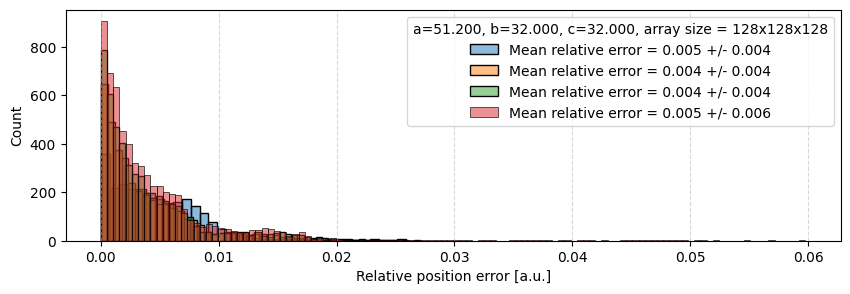

In [28]:
import matplotlib as mpl
mpl.style.use('default')

size = 128
b, c = 0.5, 0.5
number_of_ellipsoids = 4

fig, ax = plt.subplots(figsize=(10,3))

for a in np.linspace(0.2, 0.8, number_of_ellipsoids):
    
    ellipsoid = sample_data.make_blurry_ellipsoid(a, b, c, size, definition_width=10)[0]
    results_reconstruction = reconstruction.reconstruct_droplet(ellipsoid, voxelsize=np.array([1,1,1]), use_dask=False,
                                                            resampling_length=3, interpolation_method='linear', trace_length=10, sampling_distance=1)

    # calculate each point's distance to the surface of the ellipsoid
    distances = []
    ellipse_points = []
    for pt in results_reconstruction[3][0]:
        ellipse_points.append(project_point_on_ellipse_surface(pt, a*size, b*size, c*size, np.array([size/2, size/2, size/2])))
        distances.append(np.linalg.norm(pt - ellipse_points[-1]))

    # relative position error in x, y and z direction
    relative_position_error = np.abs(results_reconstruction[3][0] - ellipse_points) / ellipse_points
    relative_position_error = relative_position_error.flatten()

    # plot distance distribution
    sns.histplot(data=relative_position_error, ax=ax,
                label='Mean relative error = {:.3f} +/- {:.3f}'.format(np.mean(relative_position_error), np.std(relative_position_error)),
                alpha=0.5)
ax.set_xlabel('Relative position error [a.u.]')
ax.grid(which='major', axis='x', linestyle='--', alpha=0.5)
ax.legend(title='a={:.3f}, b={:.3f}, c={:.3f}, array size = {size}x{size}x{size}'.format(a*size/2, b*size/2, c*size/2, size=size))

## Relative and absolute mean curvature deviation

Mean curvature $H$ on an ellipse is given by the [following formula](https://mathworld.wolfram.com/Ellipsoid.html):

$H = \frac{a b c [3(a^2+b^2) + 2c^2 + (a^2 + b^2 -2c^2)cos(2\phi) - 2(a^2 - b^2)cos(2\theta)sin^2(\phi)]}{8[a^2b^2cos^2(\phi) + c^2(b^2 cos^2(\theta) + a^2 sin^2 (\theta)) sin^2\phi]^{3/2}}$

where a, b and c are the major axis length of the ellipsoid. The angles $\theta$ and $\phi$ denote the location on the surface of the ellipsoid in polar coordinates (azimuth $\theta \in [0, 2\pi]$, elevation $\phi \in [0, \pi]$). We can thus compare all measurements of mean curvature on an ellipsoid to the "true" mean curvature.

In [61]:
def theoretical_mean_curvature_on_pointcloud(a, b, c, pointcloud) -> float:
    """Theoretical mean curvature of an ellipsoid.

    Parameters
    ----------
    a : float
        Length of the first semi-axis.
    b : float
        Length of the second semi-axis.
    c : float
        Length of the third semi-axis.
    elevation : float
        Angular position of sample on ellipsoid surface
    azimuth : float
        Equatorial position of sample on ellipsoid surface
    """

    pointcloud = pointcloud - pointcloud.mean(axis=0)[None, :]
    
    pointcloud_spherical = vedo.cart2spher(pointcloud[:, 2], pointcloud[:, 1], pointcloud[:, 0])
    elevation = pointcloud_spherical[1]
    azimuth = pointcloud_spherical[2]
    
    above = a * b * c * (3 * (a**2 + b**2) + 2*c**2 + (a**2 + b**2 - 2*c**2)*np.cos(2*elevation) - 2*(a**2 - b**2)*np.cos(2*azimuth) * np.sin(elevation)**2)
    below = 8 * (a**2 * b**2 *np.cos(elevation)**2 + c**2 * (b**2 * np.cos(azimuth)**2 + a**2 * np.sin(azimuth)**2) * np.sin(elevation)**2)**(3/2)
    return above/below

Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity
Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity
Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity
Error in PyGeodesicAlgorithmExact.geodesicDistances: zero-size array to reduction operation minimum which has no identity


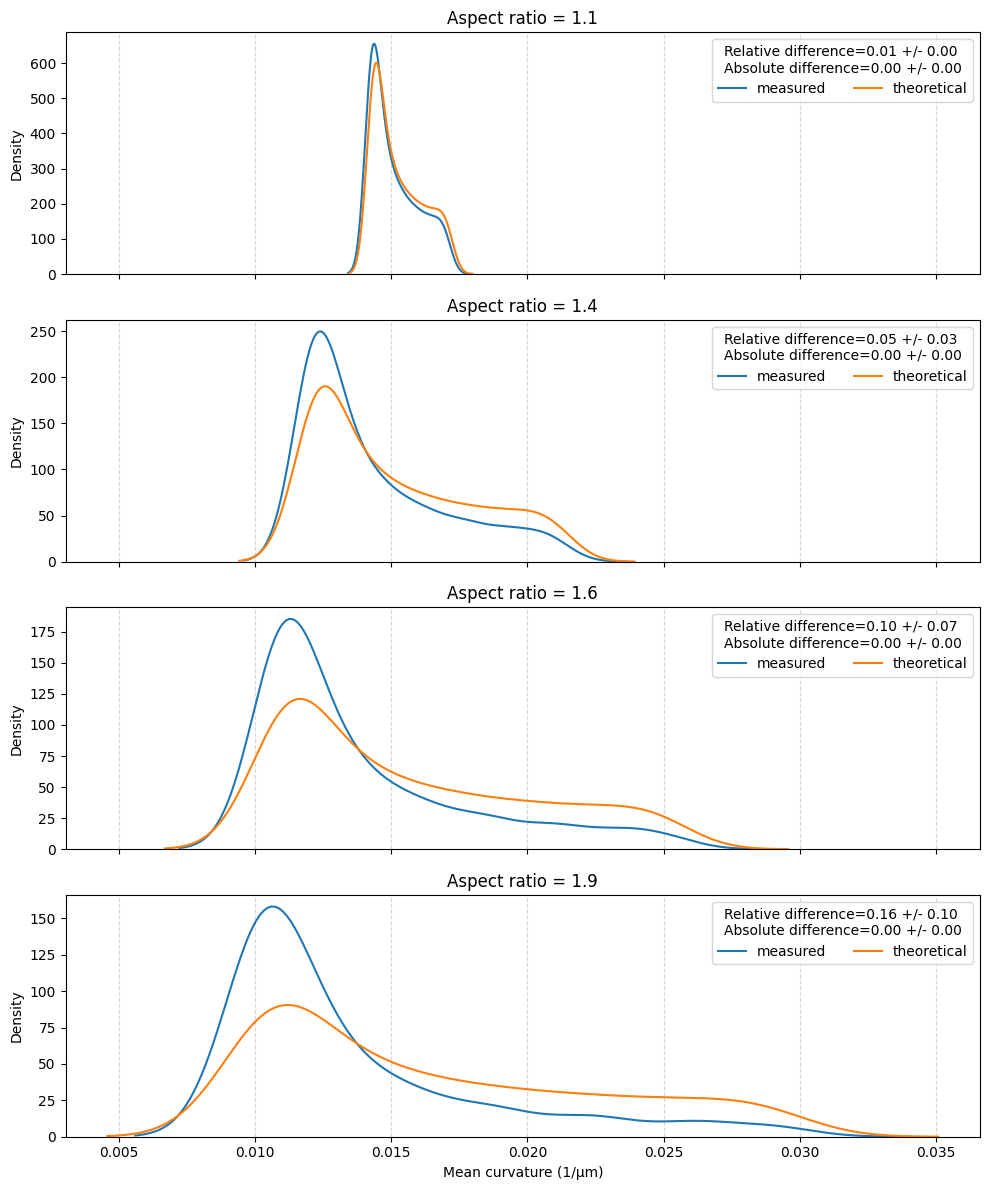

In [103]:
size = 256
b, c = 0.5, 0.5
number_of_ellipsoids = 4

fig, axes = plt.subplots(nrows=number_of_ellipsoids, figsize=(10,3 * number_of_ellipsoids), sharex=True)

for ax, a in zip(axes, np.linspace(0.55, 0.95, number_of_ellipsoids)):
    
    ellipsoid = sample_data.make_blurry_ellipsoid(a, b, c, size, definition_width=10)[0]
    results_reconstruction = reconstruction.reconstruct_droplet(ellipsoid, voxelsize=np.array([1,1,1]), use_dask=False,
                                                            resampling_length=3, interpolation_method='linear', trace_length=10, sampling_distance=1)
    results_measurement = measurements.comprehensive_analysis(results_reconstruction[3][0], max_degree=20, n_quadrature_points=434, gamma=5)

    mean_curvature_measured = results_measurement[3][1]['features']['mean_curvature']
    mean_curvature_theoretical = theoretical_mean_curvature_on_pointcloud(c * size/2, b * size/2, a * size/2,
                                                                          results_measurement[4][0])
    relative_difference = np.abs(mean_curvature_measured - mean_curvature_theoretical) / mean_curvature_theoretical
    absolute_difference = np.abs(mean_curvature_measured - mean_curvature_theoretical)
    
    sns.kdeplot(data=mean_curvature_measured, ax=ax, label='measured')
    sns.kdeplot(data=mean_curvature_theoretical, ax=ax, label='theoretical')
    ax.set_xlabel('Mean curvature (1/µm)')
    ax.grid(which='major', axis='x', linestyle='--', alpha=0.5)
    ax.set_title('Aspect ratio = {:.1f}'.format(a/b))
    ax.legend(ncols=2, title='Relative difference={:.2f} +/- {:.2f}\nAbsolute difference={:.2f} +/- {:.2f}'.format(np.mean(relative_difference),
                                                                                                                            np.std(relative_difference),
                                                                                                                            np.mean(absolute_difference),
                                                                                                                            np.std(absolute_difference)))
fig.tight_layout()